In [ ]:
#| default_exp MultiModal

In [ ]:

My [Nano GPT](https://tripathysagar.github.io/sagaTrip/gptdecoder.html) model could write Shakespeare-style text. Cool. But it had no idea what a boot looked like. Time to teach it. 

But here's the problem: images and text are fundamentally different beasts. Text? Nice, tidy tokens. Images? Thousands of pixels, each with values from 0-255. The model needs to make sense of *both* simultaneously.

**Aim:** Following the spirit of faster iteration and rapid experimentation, I built a text-to-text model (takes text input, predicts text output). The goal: expand this to handle **multimodal inputs**—learning to generate text captions from images. 

The experiment uses Shakespeare text for language modeling and Fashion-MNIST images with captions for vision-language tasks. This architecture pattern is similar to modern models like LLaVA. The model learns that `👢 → 'simple boot'`

Please check the complete [blog](https://tripathysagar.github.io/sagaTrip/multimodal.html) and inspiration.



In [1]:
try:
    import google.colab
    !pip install -q git+https://github.com/tripathysagar/NanoTransformer.git
except Exception as e:
    pass

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#|export
from NanoTransformer.data import *
from NanoTransformer.GPTText2Text import *
from NanoTransformer.ImageEncoder import *

In [ ]:
#|export

#text dataloders
text_dl = get_text_dl()
text_dl

{'train': <torch.utils.data.dataloader.DataLoader at 0x7945d0b316a0>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7945d0b323f0>}

In [4]:
for x,y in text_dl['train']:
    break
x.shape, y.shape

(torch.Size([64, 128]), torch.Size([64, 128]))

In [ ]:
#|export

from fastcore.all import *
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch

In [6]:
train_ds = MNISTDataset(tokenizer, path)
im, lbl_inp, lbl_tgt = train_ds[0]
im.shape, lbl_inp, lbl_tgt

(torch.Size([1, 28, 28]),
 tensor([57, 58, 39, 52, 42, 39, 56, 42,  1, 40, 53, 53, 58]),
 tensor([57, 58, 39, 52, 42, 39, 56, 42,  1, 40, 53, 53, 58,  0]))

In [7]:
tokenizer.decode(lbl_inp), tokenizer.decode(lbl_tgt)

('standard boot', 'standard boot\n')

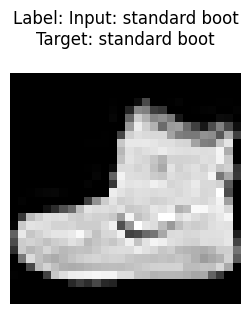

In [8]:
show_images(im, f"Input: {tokenizer.decode(lbl_inp)}\nTarget: {tokenizer.decode(lbl_tgt)}")

In [ ]:
#|export

vision_dl = get_mnist_caption_dl(tokenizer, path, 512)
len(vision_dl['train']), len(vision_dl['valid'])

(118, 20)

In [10]:
len(text_dl['train']), len(text_dl['valid'])

(123, 14)

In [11]:
ims, inp, tgt = next(iter(vision_dl['train']))

assert ims.shape[0] == inp.shape[0] == tgt.shape[0]
assert ims.shape[1:] == torch.Size([1, 28, 28])
inp.shape, tgt.shape

(torch.Size([512, 19]), torch.Size([512, 20]))

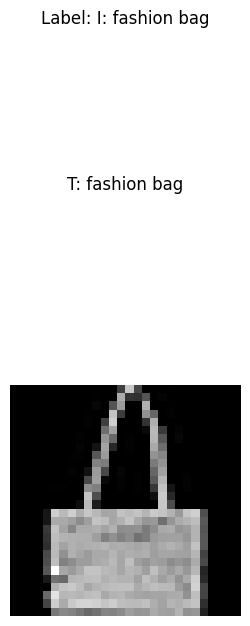

In [12]:
show_images(ims[0], f"I: {tokenizer.decode(inp[0])}T: {tokenizer.decode(tgt[0])}")

## Training Vision Encoder

In [ ]:
# train the vison encoder
vision_encoder_train(classifier, 15)

Epoch 	Train Loss 	Valid Loss 	accurecy
1   	0.4404   	0.3213		0.8855
2   	0.3017   	0.2677		0.9011
3   	0.2516   	0.2030		0.9230
4   	0.2130   	0.1645		0.9402
5   	0.1845   	0.1462		0.9454
6   	0.1591   	0.1149		0.9577
7   	0.1374   	0.1216		0.9533
8   	0.1115   	0.1014		0.9614
9   	0.0944   	0.0665		0.9757
10   	0.0809   	0.0524		0.9816
11   	0.0673   	0.0500		0.9817
12   	0.0609   	0.0405		0.9857
13   	0.0546   	0.0467		0.9830
14   	0.0468   	0.0348		0.9874
15   	0.0456   	0.0252		0.9914


## Model

Updating the embedding to take in image in first postions, by adding a paramer `start_idx` and defults to `0` for image it will be `1`.

In [14]:
#|export
import torch
from torch import nn
class Embedding(nn.Module):
    def __init__(self, config:GPTConfig):
        super().__init__()
        self.register_buffer('pos_ids', torch.arange(config.seq_len))  # for adding the postional encoding from 0 to seq_len - 1

        self.embed = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.pos_embed =  nn.Embedding(config.seq_len, config.embedding_dim)

    def forward(self, x, start_idx=0):           #bs * seq_len
        return self.embed(x) + self.pos_embed(self.pos_ids[start_idx:start_idx+x.size(1)])     #bs * seq_len * embedding_dim


In [15]:
#|export
class MultiModal(nn.Module):
    def __init__(self):
        super().__init__()

        self.vis_encoder = classifier[0]
        self.proj_layer = nn.Linear(visConfig.head_op_dim, gptConfig.embedding_dim)

        self.embed = Embedding(gptConfig)
        self.blocks = nn.ModuleList(
            [
                nn.Sequential(MultiHeadAttention(gptConfig), FFN(gptConfig))
                for _ in range(gptConfig.n_layers)
            ])
        self.layer_norm = nn.LayerNorm(gptConfig.embedding_dim)
        self.lm_head = nn.Linear(gptConfig.embedding_dim, gptConfig.vocab_size)

        for param in self.vis_encoder.parameters():       #freezing the vision encoder
            param.requires_grad = False

    def forward(self, text_idx, image=None):
        if image is not None:
            # Ensure image has the correct dtype before passing to the encoder
            image = image.to(self.proj_layer.weight.dtype)                     # ensure the image input has the correct data type
            img_emb = self.proj_layer(self.vis_encoder(image)).unsqueeze(1)    # (bs, 1, 128)
            img_emb = img_emb + self.embed.pos_embed(self.embed.pos_ids[0:1])  # fetch embeddings at the 0th idx
            text_emb = self.embed(text_idx, start_idx=1)                       # positions start at 1
            x = torch.cat([img_emb, text_emb], dim=1)
        else:
            x = self.embed(text_idx)

        for block in self.blocks:
            x = block(x)
        return self.lm_head(self.layer_norm(x))

## Config

In [ ]:
#|export
from dataclasses import dataclass

@dataclass
class MultiModalConfig:
    bs = 256

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16 # Use bfloat16 on Ampere+ GPUs, otherwise use float16

    lr = 1e-3
    max_grad_norm = 1.0

    num_steps_per_epoch = min(len(text_dl['train']), len(dls['train']))
    epochs = 20

multiConfig = MultiModalConfig()

## Data iterators

1. TrainBatchIter: for iterating for data for text_dl and vision_dl at a batch sequentially
2. ValidBatchIter: for iterating for data for text_dl and vision_dl at a batch exaustly

In [ ]:
#|export

class TrainBatchIter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.text_dl = iter(text_dl['train'])
        self.vision_dl = iter(vision_dl['train'])
        self.idx = -1
        self.text_exhausted = False
        self.vision_exhausted = False

    def __iter__(self):
        return self

    def __next__(self):
        # If both exhausted, stop
        if self.text_exhausted and self.vision_exhausted:
            raise StopIteration

        self.idx += 1
        use_text = (self.idx % 2 == 0)

        # Adjust if chosen iterator is exhausted
        if use_text and self.text_exhausted:
            use_text = False
        elif not use_text and self.vision_exhausted:
            use_text = True

        # Try to get batch
        try:
            if use_text:
                x, y = next(self.text_dl)
                return x, y, None
            else:
                images, x, y = next(self.vision_dl)
                return x, y, images
        except StopIteration:
            # Mark as exhausted and try the other
            if use_text:
                self.text_exhausted = True
                try:
                    images, x, y = next(self.vision_dl)
                    return x, y, images
                except StopIteration:
                    self.vision_exhausted = True
                    raise
            else:
                self.vision_exhausted = True
                try:
                    x, y = next(self.text_dl)
                    return x, y, None
                except StopIteration:
                    self.text_exhausted = True
                    raise

In [ ]:
#|export

class ValidBatchIter:
    def __init__(self):
        self.reset()

    def reset(self):
        # Reset the iters
        self.text_dl = iter(text_dl['valid'])
        self.vision_dl = iter(vision_dl['valid'])
        self.text_exhausted = False
        self.vision_exhausted = False

    def __iter__(self):
        return self

    def __next__(self):
        # If both exhausted, stop
        if not self.text_exhausted:
            #iter through the text data first
            #once exausted do not raise stop iter instead iter through vision data
            try:
                x, y = next(self.text_dl)
                return x, y, None
            except StopIteration:
                self.text_exhausted = True

        if self.text_exhausted:
          try:
            # fetch vision data
            images, x, y = next(self.vision_dl)
            return x, y, images

          except StopIteration:
            self.vision_exhausted = True
            raise StopIteration

## Training

In [19]:
#|export
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

model = MultiModal().to(multiConfig.device)
optimizer = AdamW(model.parameters(), lr=multiConfig.lr)

In [ ]:
#|export

train_iters = TrainBatchIter()
valid_iters = ValidBatchIter()

In [ ]:
#|export

def pred(text_input, ims):
  """prediction for given text and image"""
  return model(text_input, ims)

In [22]:
loss_func

CrossEntropyLoss()

In [ ]:
#|export

def cal_loss(logits, text_target):
  """calculate the loss for pred and target"""
  return loss_func(logits.reshape(-1, gptConfig.vocab_size), text_target.reshape(-1))

In [24]:
loss = 0
for x, y in text_dl['train']:
  x, y = x.to(multiConfig.device), y.to(multiConfig.device)
  logits = pred(x, None)
  loss = cal_loss(logits, y)
  break
loss/len(text_dl['train'])

tensor(0.0360, device='cuda:0', grad_fn=<DivBackward0>)

### Loss calculate

In [ ]:
#|export

def calculate_text_loss(data_dl):
    total_loss = 0
    num_batches = 0

    for x, y in data_dl:
        x, y = x.to(multiConfig.device), y.to(multiConfig.device)

        with torch.no_grad():
          logits = pred(x, None)
          loss = cal_loss(logits, y)

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

In [26]:
(calculate_text_loss(text_dl['train']) + calculate_text_loss(text_dl['valid'])) / 2

4.4335325311146825

In [ ]:
#|export

def calculate_vision_loss(data_dl):
    total_loss = 0
    num_batches = 0

    for ims, x, y in data_dl:
        ims = ims.to(multiConfig.device)
        x, y = x.to(multiConfig.device), y.to(multiConfig.device)

        with torch.no_grad():
          logits = pred(x, ims)
          loss = cal_loss(logits, y)

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches
(calculate_vision_loss(vision_dl['train']) + calculate_vision_loss(vision_dl['valid'])) / 2

4.4847678228960195

In [ ]:
#|export

def cal_indivisual_loss():
  text_loss = (calculate_text_loss(text_dl['train']) + calculate_text_loss(text_dl['valid'])) / 2
  vision_loss = (calculate_vision_loss(vision_dl['train']) + calculate_vision_loss(vision_dl['valid'])) / 2
  print(f"Text Loss: {text_loss:.4f} | Vision Loss: {vision_loss:.4f}")
cal_indivisual_loss()

Text Loss: 4.4333 | Vision Loss: 4.4840


### Training loss

In [ ]:
#|export

for epoch in range(30):
    model.train()
    train_loss, no_train = 0, 0
    train_iters.reset()

    for text_input, text_target, ims in train_iters: # Iterate directly over iters
        no_train += 1
        # Handle None for images
        if ims is not None:
            ims = ims.to(multiConfig.device)

        text_input, text_target = text_input.to(multiConfig.device), text_target.to(multiConfig.device)

        optimizer.zero_grad()

        with torch.autocast(device_type=multiConfig.device, dtype=multiConfig.dtype):
          logits = pred(text_input, ims) #model(text_input, ims)

          loss = cal_loss(logits, text_target)    #loss_func(logits.reshape(-1, gptConfig.vocab_size), text_target.reshape(-1))

        loss.backward()

        clip_grad_norm_(model.parameters(), gptConfig.max_grad_norm) # to clip gradients

        optimizer.step()

        train_loss += loss.item()

    valid_iters.reset()
    model.eval()
    val_loss, no_valid = 0, 0
    with torch.no_grad(), torch.autocast(device_type=gptConfig.device, dtype=gptConfig.dtype):
        for text_input, text_target, ims in valid_iters:
            no_valid += 1

            if ims is not None: ims = ims.to(multiConfig.device)

            text_input, text_target = text_input.to(multiConfig.device), text_target.to(multiConfig.device)

            logits = pred(text_input, ims)

            loss = cal_loss(logits, text_target)

            val_loss += loss.item()

    print(f"{epoch} -> {train_loss/no_train:.4f} : {val_loss/no_valid:.4f}")

0 -> 1.6584 : 1.1541
1 -> 1.3241 : 1.0720
2 -> 1.2224 : 0.9973
3 -> 1.1345 : 0.9514
4 -> 1.0675 : 0.9101
5 -> 1.0162 : 0.8810
6 -> 0.9780 : 0.8623
7 -> 0.9473 : 0.8486
8 -> 0.9239 : 0.8299
9 -> 0.9054 : 0.8241
10 -> 0.8896 : 0.8102
11 -> 0.8766 : 0.8108
12 -> 0.8657 : 0.7986
13 -> 0.8556 : 0.7962
14 -> 0.8473 : 0.7877
15 -> 0.8402 : 0.7822
16 -> 0.8333 : 0.7847
17 -> 0.8269 : 0.7806
18 -> 0.8214 : 0.7790
19 -> 0.8161 : 0.7748
20 -> 0.8116 : 0.7767
21 -> 0.8066 : 0.7784
22 -> 0.8032 : 0.7710
23 -> 0.7990 : 0.7684
24 -> 0.7954 : 0.7709
25 -> 0.7924 : 0.7692
26 -> 0.7890 : 0.7705
27 -> 0.7859 : 0.7638
28 -> 0.7832 : 0.7664
29 -> 0.7805 : 0.7716


### Loss after training

In [30]:
cal_indivisual_loss()

Text Loss: 1.4363 | Vision Loss: 0.1729


## Inferenece

### Image

In [ ]:
#|export

@torch.no_grad()
def generate_caption(image, max_len=30):
    model.eval()
    image = image.unsqueeze(0).to(multiConfig.device).to(multiConfig.dtype)  # Add batch dimension and move to device with correct dtype

    generated = []
    text_idx = torch.empty((1, 0), dtype=torch.long, device=multiConfig.device)  # Empty text

    for _ in range(max_len):
        logits = model(text_idx, image)
        next_token = logits[:, -1, :].argmax(dim=-1)

        # Check for stop token '\n'
        if tokenizer.decode([next_token.item()]) == '\n':
            break

        generated.append(next_token.item())
        text_idx = torch.cat([text_idx, next_token.unsqueeze(0)], dim=1)

    return tokenizer.decode(generated)

Fetch the class from the caption generated

In [ ]:
#|export

find_lbl = lambda lable: [key for key, values in captions.items() if lable in values]

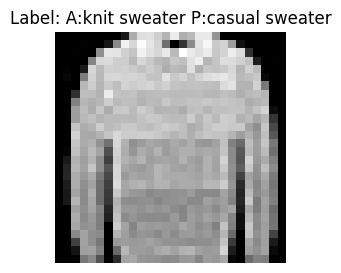

In [34]:
ims, inp, tgt = next(iter(vision_dl['valid']))

idx = 20
actual_caption = tokenizer.decode(inp[idx]).split('\n')[0]  # as \n is padded to the label
pred_caption = generate_caption(ims[idx])

show_images(ims[idx], f"A:{actual_caption} P:{pred_caption}")

In [35]:
actual_caption, pred_caption

('knit sweater', 'casual sweater')

In [36]:
find_lbl(actual_caption), find_lbl(pred_caption)

([2], [2])

### Text

In [ ]:
#|export

@torch.no_grad()
def generate_text(prompt, max_new_tokens=100, temperature=1.0):
    """
    prompt: string to start generation
    max_new_tokens: how many tokens to generate
    temperature: higher = more random, lower = more deterministic
    """
    model.eval()
    tokens = tokenizer.encode(prompt)
    tokens = torch.tensor(tokens).unsqueeze(0)  # Add batch dim
    tokens = tokens.to('cuda')
    for _ in range(max_new_tokens):
        # Crop to last seq_len tokens if needed
        context = tokens if tokens.size(1) <= model.embed.pos_ids.size(0) else tokens[:, -model.embed.pos_ids.size(0):]

        # Get predictions
        with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.bfloat16):
          logits = model(context)
        logits = logits[:, -1, :] / temperature  # Focus on last token

        # Sample next token
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # Append to sequence
        tokens = torch.cat([tokens, next_token], dim=1)

    return tokenizer.decode(tokens.squeeze().tolist())
print(generate_text("To be or not to be", max_new_tokens=256))

To be or not to beast.
And gave me resolved them and lips to hear.
This hath prevent so you and thou, I were, good their
Frozing in a curse; and acchive of a blous,
Whose as hear me, thank, over with wind fair,
And against the pave of him.
'Duke his wrongly souls, holy, and
